### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
import matplotlib.pyplot as plt
from gym import spaces
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent, RussoAgent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment object and running it
In the following cell we instanciate a dynamical model (of the `ModelDynamics` class) that implements the epidemic simulation. The simulation parameters are set by the config file that we load (here `switzerland.yaml`). We then demonstrate how one can query the list of cities from the dynamical model and how one can plot the map on which the simulation will happen. 

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map


# Question 4.2

In [3]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    keys = ['confinement', 'isolation', 'hospital', 'vaccinate']
    
    # Create a dictionnary where values of 'a' are transformed in bool and assigned to a key 
    action = dict(zip(keys, np.array(a, dtype=bool).T))
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    infected = infected**(1/4)
    dead = dead**(1/4)
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [4]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [5]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor
            )

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class FactorizedQ(Agent):
    def __init__(self,  env:Env, memory_size=20000 ,learning_rate = 0.005, discount_factor = 0.9):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.HuberLoss()
        self.gamma = discount_factor
        
    
    def create_model(self):
        obs_dim = self.env.observation_space.shape[0]*self.env.observation_space.shape[1]*self.env.observation_space.shape[2]
        action_dim = self.env.action_space.shape[0]*2
        model = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model.load_state_dict(torch.load(savepath))
        

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)  # Save the best model
    

    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        batch_states = torch.stack(states)
        batch_actions = np.array(actions)
        batch_actions = torch.ByteTensor(batch_actions)
        batch_rewards = torch.stack(rewards).squeeze()
        batch_next_states = torch.stack(next_states).squeeze(1)
        batch_dones = torch.ByteTensor(np.array(dones).astype(int))
        
        # Reshape the q values array from shape (8,1) to (4,2)
        curr_Q = self.model(batch_states).reshape((batch_size, self.env.action_space.shape[0], 2))

        #Compute the actual Q summing the qvalues corresponding to the actions taken
        curr_Q = curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions.long()].sum(-1)

        # Compute the best Q for this state summing over the max Qa
        next_Q = self.target_model(batch_next_states)
        next_Q = next_Q.reshape((batch_size, self.env.action_space.shape[0], 2)).max(-1)[0].sum(-1)
        
        target_Q = batch_rewards + (1 - batch_dones) * self.gamma * next_Q # gamma is the discount factor
        loss = self.loss_fn(curr_Q, target_Q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def reset(self,seed = None):
        # This should be called when the environment is reset
        torch.manual_seed(seed)
        torch.use_deterministic_algorithms(True)
        random.seed(seed)
        self.env.reset(seed)
    
    def act(self, obs, exploration = True):
        # this takes an observation and returns 4 actions
        # the action space can be directly sampled from the env
        state = obs[0,:2].flatten()
        if (random.random() < self.epsilon) and exploration : # Exploration
            return self.env.action_space.sample()

        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
                # Reshape action_values to gather actions [[a_conf=TRUE, a_conf=FALSE], ...]
                q_values = torch.reshape(q_values, (4,2))
            
            # Return an array of size 4 with binary choice [conf, isol, hosp, vacc]
            return torch.argmax(q_values, dim = -1).numpy()

    def remember(self, state, action, reward, next_state, done):
        state = state[0,:2].flatten()
        next_state = next_state[0,:2].flatten()
        self.memory.append((state, action, reward, next_state, done))

In [7]:
N_EPISODES = 500
EVAL_INTERVAL = 50
NUM_EVAL_EPISODES = 20
TARGET_UPDATE_INTERVAL = 5  # Update target network every 5 episodes

BATCH_SIZE = 2048
BUFFER_SIZE = 20000
LR = 1e-5   # learning rate
GAMMA = 0.9 # discount factor

epsilon_start = 0.7
epsilon_end = 0.2
epsilon_decay = 995.  # 0.995

input_shape = 126  # 2*9*7
action_size = 8  # binary action space
seed = 42  # or any other seed you want to use for reproducibility

agent = FactorizedQ(env, memory_size = BUFFER_SIZE, learning_rate=LR, discount_factor=GAMMA)  # Assume you've defined input_shape, action_size, seed
agent.epsilon = epsilon_start

# Seed the environement and the agent for reproductiveness
agent.reset(seed)
np.random.seed(seed)
seeds = np.random.randint(0, 1e6, N_EPISODES)

log = {
    'Episode': [i + 1 for i in range(N_EPISODES)],
    'conf_days': [],
    'R_cumul': [],
    'N_deaths': [],
    'eval_trace': []
}

best_eval_reward = -np.inf

""" Run several simulations """
for i in tqdm(range(N_EPISODES)):
    finished = False
    obs, info = agent.env.reset(seeds[i])
    N_confin = 0
    R_cumul = 0
    
    if i % TARGET_UPDATE_INTERVAL == 0:
        agent.update_target_model()

    while not finished:
        action = agent.act(obs)
        next_obs, R, finished, info = agent.env.step(action)

        R_cumul += R
        N_confin += info.action['confinement'] * 7

        # Store the transition in memory
        agent.remember(obs, action, R, next_obs, finished)

        # Train the model
        agent.optimize_model(BATCH_SIZE)  

        obs = next_obs

        if finished:
            break
            
    # Decay epsilon
    agent.epsilon = max(epsilon_end, epsilon_start * (N_EPISODES-i)/N_EPISODES)

    log['conf_days'].append(N_confin)
    log['R_cumul'].append(R_cumul.numpy()[0])
    log['N_deaths'].append(info.total.dead)

    # Evaluation and logging
    if i % EVAL_INTERVAL == 0 or (i == N_EPISODES - 1 and N_EPISODES % EVAL_INTERVAL != 0):
        eval_rewards = []
        
        for idx in range(NUM_EVAL_EPISODES):
            obs, info = agent.env.reset(seeds[idx] + 1) # Always do the validation on the same environements
            episode_reward = 0
            done = False
            while not done:                
                action = agent.act(obs, exploration=False) # No exploration
                obs, reward, done, _ = agent.env.step(action)
                episode_reward += reward
            eval_rewards.append(episode_reward)

        eval_rewards = [reward.item() for reward in eval_rewards]
        avg_eval_reward = np.mean(eval_rewards)
        log['eval_trace'].append(avg_eval_reward)
        print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}")

        # Save the best model
        if avg_eval_reward > best_eval_reward:
            best_eval_reward = avg_eval_reward
            agent.save_model('logs/best_model_4_2.pt')  # Save the best model


  0%|          | 1/500 [00:06<50:03,  6.02s/it]

Episode 1, Avg Eval Reward: 14.906984567642212


 10%|█         | 51/500 [00:32<19:40,  2.63s/it]

Episode 51, Avg Eval Reward: 14.906984567642212


 20%|██        | 101/500 [01:06<18:48,  2.83s/it]

Episode 101, Avg Eval Reward: -59.031873035430905


 30%|███       | 151/500 [01:45<17:23,  2.99s/it]

Episode 151, Avg Eval Reward: -83.4703839302063


 40%|████      | 201/500 [02:24<14:39,  2.94s/it]

Episode 201, Avg Eval Reward: -152.34758377075195


 50%|█████     | 251/500 [03:03<11:41,  2.82s/it]

Episode 251, Avg Eval Reward: -162.7489158630371


 60%|██████    | 301/500 [03:40<09:17,  2.80s/it]

Episode 301, Avg Eval Reward: -162.7489158630371


 70%|███████   | 351/500 [04:17<07:05,  2.86s/it]

Episode 351, Avg Eval Reward: -162.7489158630371


 80%|████████  | 401/500 [04:57<04:38,  2.82s/it]

Episode 401, Avg Eval Reward: -134.78034324645995


 90%|█████████ | 451/500 [05:34<02:18,  2.83s/it]

Episode 451, Avg Eval Reward: -70.23608474731445


100%|██████████| 500/500 [06:04<00:00,  1.37it/s]


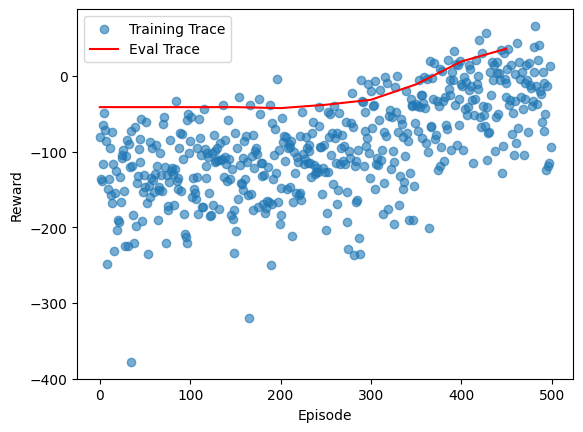

In [8]:
import matplotlib.pyplot as plt

# Extract rewards from log
training_rewards = log['R_cumul']
eval_rewards = log['eval_trace']

# Generate x values
x_train = range(len(training_rewards))
x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

# Create new figure
plt.figure()

# Plot training trace
plt.scatter(x_train, training_rewards, label='Training Trace', alpha=0.6)

# Plot evaluation trace
plt.plot(x_eval, eval_rewards, label='Eval Trace', color='red')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Show the plot
plt.show()


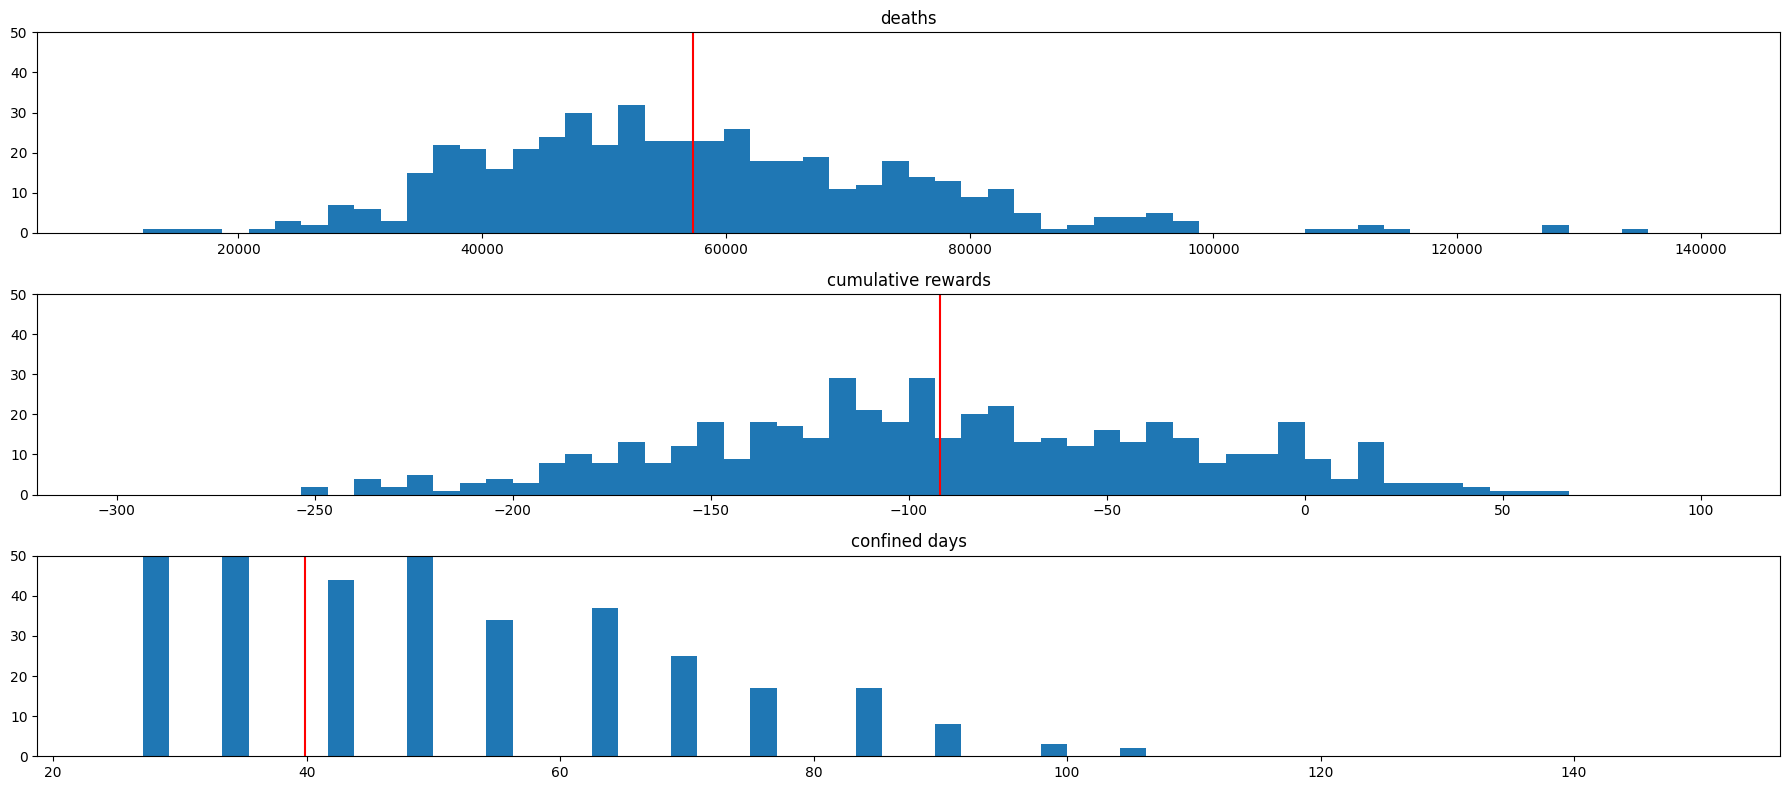

Average death number: 57295.6
Average number of confined days: 39.858
Average number of isolation days: 39.858
Average cumulative reward: -92.1021957397461
Maximum cumulative rewards: 65.92256927490234, corresponding to 42 days of confinement and resulting in 51809 deaths.


In [9]:
deaths = np.array(log['N_deaths'])
rewards = np.array(log['R_cumul'])
conf_days = np.array(log['conf_days'])


""" Plot example """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10000,140000)
    elif title == 'cumulative rewards': 
        x_range = (-300,100)
    elif 'days' in title:
        x_range = (25,150)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Maximum cumulative rewards: {np.amax(rewards)}, corresponding to {conf_days[np.argmax(reward)]} days of confinement and resulting in {deaths[np.argmax(reward)]} deaths.')

In [10]:
# Run several episodes of evaluation and plot one of them
inferences_rewards = []
log_eval = {'info':[], 'rewards':[], 'dead':[], 'conf_days':[], 'isol_days':[], 'vacc_days':[], 'hosp_days':[]}
N_EPISODES_EVAL = 50

for idx in range(N_EPISODES_EVAL):
    obs, info = agent.env.reset() # Need to hardcode the seed, otherwise it doesnt work I don't know why
    episode_reward = 0 
    done = False
    _ = []
    conf_days = 0
    isol_days = 0
    vacc_days = 0 
    hosp_days = 0
    while not done:                
        action = agent.act(obs, exploration=False) # No exploration
        obs, reward, done, info = agent.env.step(action)
        _.append(info)
        episode_reward += reward.squeeze().numpy()
        conf_days += info.action['confinement'] * 7
        isol_days += info.action['isolation'] * 7
        vacc_days += info.action['vaccinate'] * 7
        hosp_days += info.action['hospital'] * 7
    log_eval['rewards'].append(episode_reward)
    log_eval['info'].append(_)
    log_eval['dead'].append(info.total.dead)
    log_eval['conf_days'].append(conf_days)
    log_eval['isol_days'].append(isol_days)
    log_eval['vacc_days'].append(vacc_days)
    log_eval['hosp_days'].append(hosp_days)

## 4.2.A

In [34]:
""" Parse a random log """
idx = random.randint(0,N_EPISODES_EVAL)
print(idx)
log_random = log_eval['info'][idx]
total = {p:np.array([getattr(l.total,p) for l in log_random]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log_random]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log_random]) for a in log_random[0].action.keys()}

11


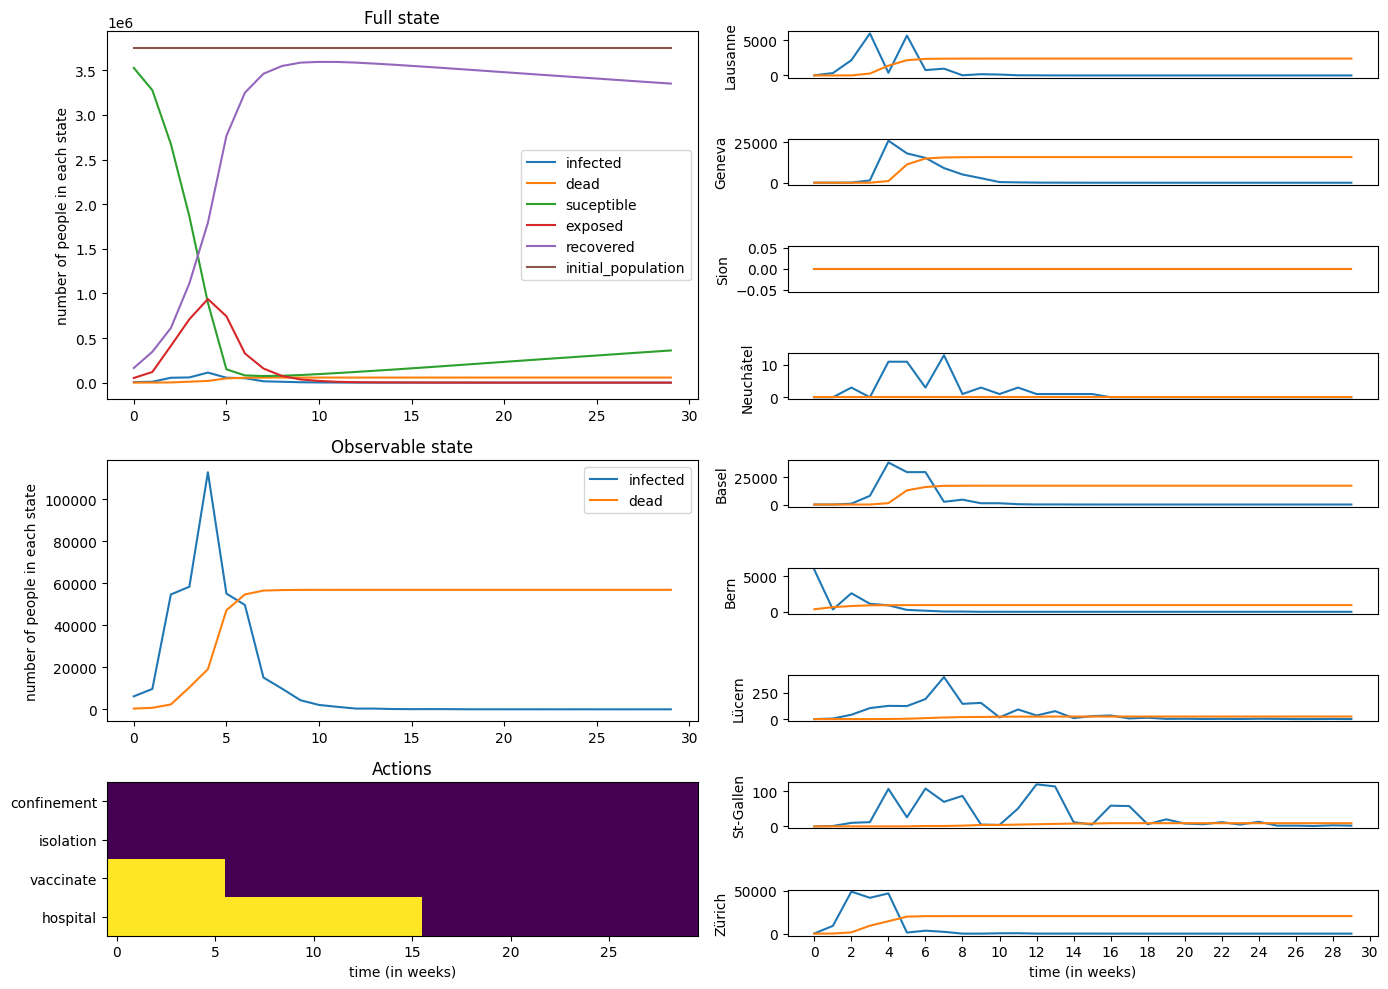

In [35]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## 4.2.b

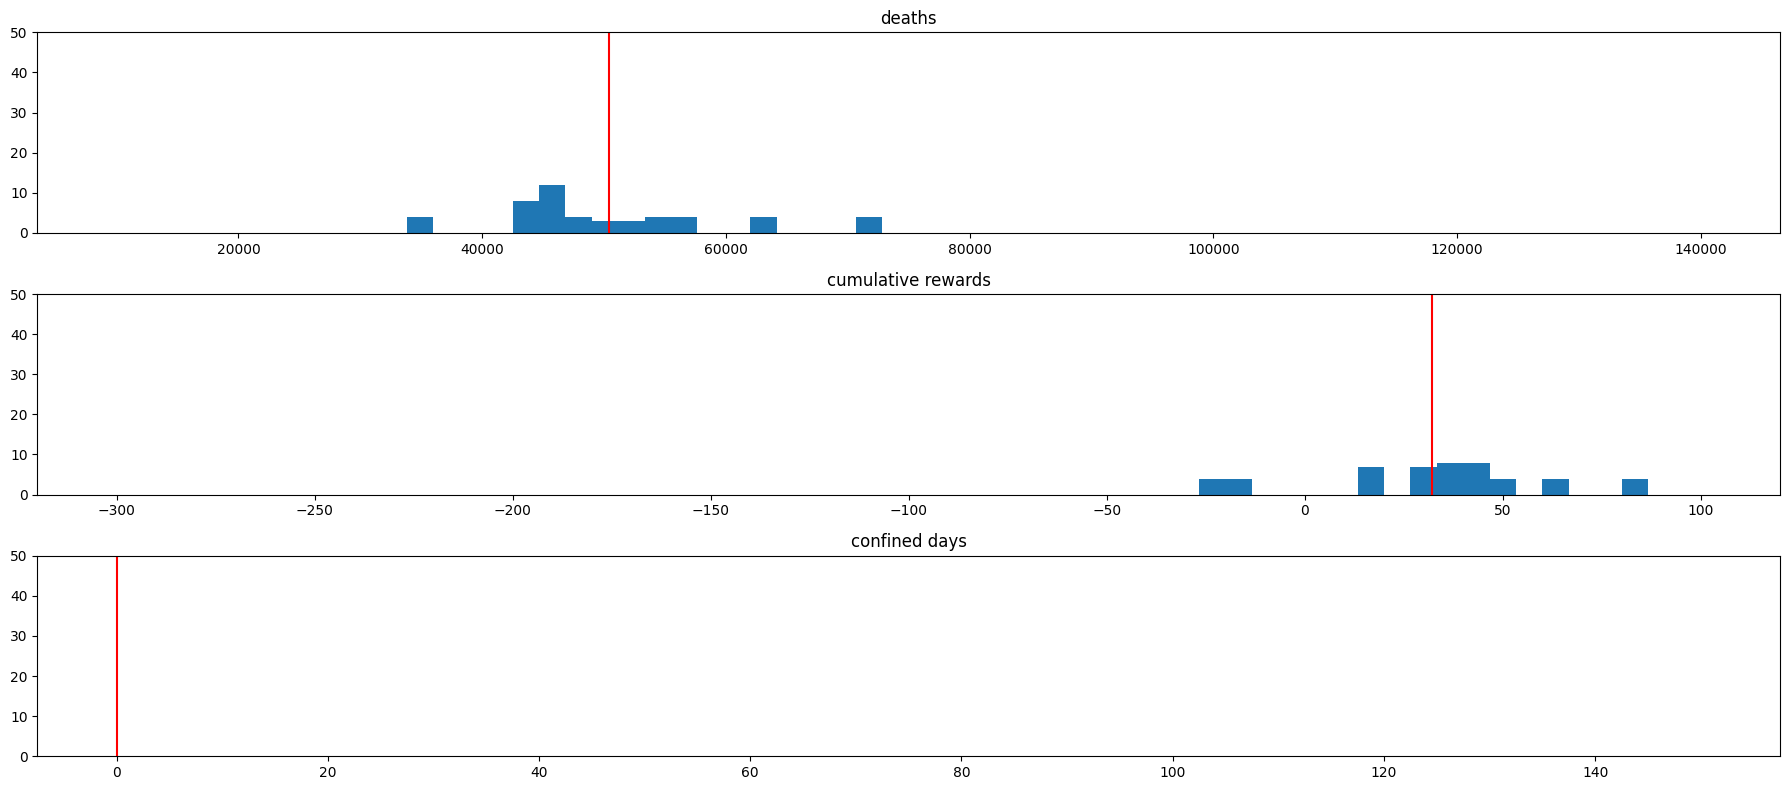

Average number of confined days: 0.0
Average number of isolation days: 6.58
Average number of vaccination days: 36.26
Average number of hospital days: 130.2
Average death number: 50439.52
Average cumulative reward: 32.241113053560255


In [36]:
deaths = np.array(log_eval['dead'])
rewards = np.array(log_eval['rewards'])
conf_days = np.array(log_eval['conf_days'])
isol_days = np.array(log_eval['isol_days'])
vacc_days = np.array(log_eval['vacc_days'])
hosp_days = np.array(log_eval['hosp_days'])


""" Plot example """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10000,140000)
    elif title == 'cumulative rewards': 
        x_range = (-300,100)
    elif 'days' in title:
        x_range = (25,150)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
# 5.b)

print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(isol_days)}')
print(f'Average number of vaccination days: {np.mean(vacc_days)}')
print(f'Average number of hospital days: {np.mean(hosp_days)}')
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

# 5.c 


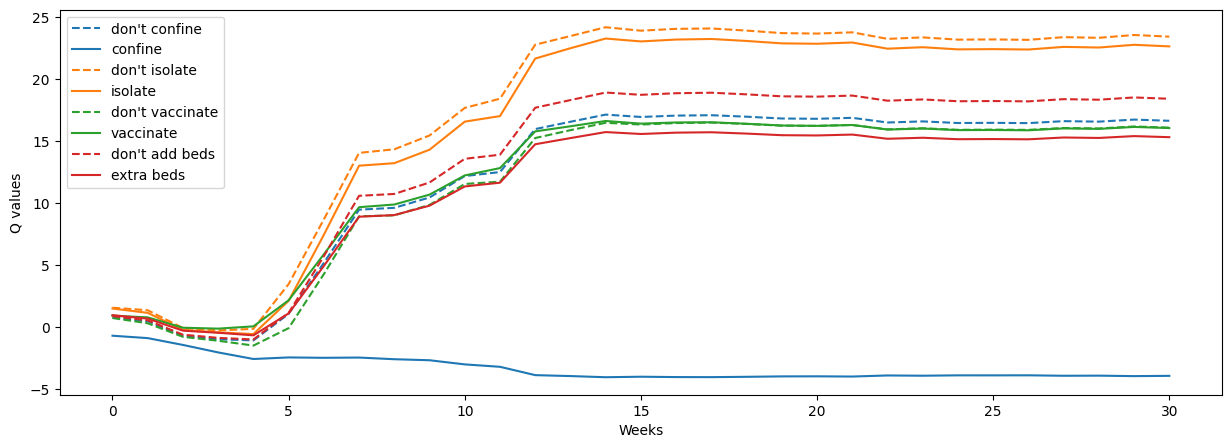

In [37]:
obs, info = agent.env.reset(0)
done = False
q_values = []
while not done:
    q_values.append(agent.model(obs[0,:2].flatten()).detach().tolist())
    action = agent.act(obs, exploration=False) # No exploration
    obs, reward, done, info = agent.env.step(action)
# For the last day
q_values.append(agent.model(obs[0,:2].flatten()).detach().tolist())               
q_values = np.array(q_values)

labels = ["don't confine", 'confine', "don't isolate", 'isolate',  "don't vaccinate", "vaccinate",  "don't add beds", "extra beds"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
color_idx = -1

plt.figure(figsize=(15,5))
for i in range(q_values.shape[1]):
    ls = None
    if i%2 == 0:
        color_idx += 1
        ls = '--'
    plt.plot(q_values[:,i], label = labels[i],ls = ls, color = colors[color_idx])
plt.ylabel('Q values')
plt.xlabel('Weeks')
plt.legend()
plt.show()

# TESTS

In [15]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [16]:
a  = torch.Tensor(np.random.randint(0, 10, size=8).reshape((4,2)))
print(torch.argmax(a, dim = 1).tolist())
print(a)

[0, 0, 0, 0]
tensor([[9., 8.],
        [6., 2.],
        [9., 5.],
        [7., 3.]])


In [17]:
actions = {
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

action_taken = [0,0,1,1]

action_taken = np.array(action_taken, dtype = bool)
for v in actions.values():
    v

In [18]:

action

array([0, 0, 0, 0])

In [19]:
batch = random.sample(agent.memory, 64)
states, actions, rewards, next_states, dones = zip(*batch)


In [20]:
batch_states = torch.stack(states)
batch_actions = np.array(actions)
batch_actions = torch.ByteTensor(actions)
batch_rewards = torch.stack(rewards)
batch_next_states = torch.stack(next_states).squeeze(1)
batch_dones = torch.ByteTensor(np.array(dones).astype(int))


print(batch_states.shape,batch_actions.shape,batch_rewards.shape,batch_next_states.shape)
print(batch_rewards)

torch.Size([64, 126]) torch.Size([64, 4]) torch.Size([64, 1, 1]) torch.Size([64, 126])
tensor([[[  7.0000]],

        [[  6.0328]],

        [[ -3.7578]],

        [[ -7.8179]],

        [[  7.0000]],

        [[  7.0000]],

        [[ -5.1008]],

        [[  6.9200]],

        [[-28.9714]],

        [[-11.0000]],

        [[  1.0000]],

        [[  7.0000]],

        [[-18.4584]],

        [[  7.0000]],

        [[  7.0000]],

        [[  0.3194]],

        [[  5.6843]],

        [[-27.9802]],

        [[-12.1077]],

        [[-12.8251]],

        [[  7.0000]],

        [[ -5.0800]],

        [[ -0.7486]],

        [[ -6.0800]],

        [[ -5.0869]],

        [[-29.7223]],

        [[  5.5736]],

        [[  4.3580]],

        [[  5.2701]],

        [[  1.0000]],

        [[ -1.9759]],

        [[ -8.8809]],

        [[  7.0000]],

        [[ -5.0800]],

        [[  6.9931]],

        [[-13.3390]],

        [[ -0.0904]],

        [[  6.7467]],

        [[  6.8645]],

        [[ -3.07

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_31615/119255941.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  batch_actions = torch.ByteTensor(actions)


In [21]:
batch_rewards.squeeze().shape

torch.Size([64])

In [22]:
curr_Q = agent.model(batch_states).reshape((64, agent.env.action_space.shape[0], 2))
#Compute the actual Q summing the qvalues corresponding to the actions taken
curr_Q = curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions].sum(-1)
# Compute the best Q for this state
next_Q = agent.target_model(batch_next_states)
next_Q = next_Q.reshape((64,4,2)).max(-1)[0].sum(-1)
batch_rewards = batch_rewards.squeeze()
target_Q = batch_rewards + (1 - batch_dones) * 0.9 * next_Q # 0.9 is the discount factor

IndexError: too many indices for tensor of dimension 3

In [ ]:
print(batch_actions)
curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions.long()]

tensor([[1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 0, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 1],
        [1, 1, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 1, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [0, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 0, 0],
        [1, 0, 1, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 1, 0, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 1],
        [1, 1, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 1, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 1],
        [0

tensor([[-0.0127,  0.2866, -0.0186, -0.0773],
        [-0.0153,  0.2863, -0.0171, -0.0778],
        [-0.0154,  0.2859, -0.0172, -0.0772],
        [-0.0097, -0.0190, -0.1248, -0.1224],
        [-0.0139,  0.2828, -0.1287, -0.0755],
        [-0.0113,  0.2921, -0.0171, -0.0776],
        [-0.0113, -0.0184, -0.0184, -0.1227],
        [-0.0199, -0.0130, -0.0189, -0.0744],
        [-0.0162,  0.2820, -0.1263, -0.0773],
        [-0.0176, -0.0088, -0.0184, -0.0748],
        [-0.0168,  0.2836, -0.0153, -0.0771],
        [-0.0195, -0.0136, -0.0143, -0.0783],
        [-0.0237,  0.2825, -0.1274, -0.1198],
        [-0.0098,  0.2878, -0.0183, -0.0773],
        [-0.0120,  0.2818, -0.1285, -0.1198],
        [-0.0268,  0.2826, -0.0203, -0.1205],
        [-0.0165,  0.2887, -0.1263, -0.1200],
        [-0.0160,  0.2859, -0.0196, -0.1166],
        [-0.0090, -0.0168, -0.0188, -0.1220],
        [-0.0171,  0.2820, -0.1255, -0.0768],
        [-0.0295,  0.2832, -0.0187, -0.1216],
        [-0.0137, -0.0125, -0.1264

In [ ]:
print(curr_Q.shape)
print(next_Q.shape)
print(batch_dones.shape)
print(batch_rewards.shape)
print(target_Q.shape)
        
loss = agent.loss_fn(curr_Q, target_Q)
print(loss)

torch.Size([64, 4, 2])


NameError: name 'next_Q' is not defined

In [ ]:
target_Q.detach().shape

In [ ]:
next_Q.reshape((64,4,2)).max(-1)[0].sum(-1)

In [ ]:
q2.gather(1, batch_actions.unsqueeze(-1)).squeeze(-1)
q2[np.arange(q2.shape[0])[:, None], np.arange(q2.shape[1]), batch_actions]

In [ ]:
info.action

{'confinement': False, 'isolation': False, 'vaccinate': True, 'hospital': True}

In [ ]:
keys = ['confinement', 'isolation', 'hospital', 'vaccinate']
# Create a dictionnary where values of 'a' are transformed in bool and assigned to a key 
action = dict(zip(keys, np.array(a, dtype=bool).T))

{'confinement': True, 'isolation': True, 'hospital': False, 'vaccinate': False}


In [ ]:
dyn.get_action()

{'confinement': False,
 'isolation': False,
 'vaccinate': False,
 'hospital': False}